In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

The goal here is to simultaneously model the stellar binary population and the planet population.  We can make the assumption that the same stellar binary population creates both the detected EBs and false positives.  

I want to parametrize the stellar companion period distribution.  Stellar companions as a whole are well modeled by a lognormal distribution, but there's this bump of short-period companions that are caused by dynamical evolution in triple systems (e.g., Figure 12 of the [latest Kepler EB paper](http://arxiv.org/pdf/1512.08830v1.pdf)).  For the purposes of single-transit exploration, it's fine to ignore that short-period bump.  And since the maximum of the solar-type star companion period distribution is at a period of about 250 years ([Duchene & Kraus](http://arxiv.org/pdf/1303.3028v1.pdf)), the period range we care about should be able to be modeled as a power law.  

$\Gamma_P \propto P^\alpha$

For `vespa` as designed for standard Kepler candidates, I synthesized new populations for each individual candidate.  Part of the reason for this is that the integration time smears out the transit shape such that the shape is not simply scalable with period.  However, for long periods it might become negligible.  I should test this.

In [9]:
# OK, first make a model of a star
# Give it sun-like spectroscopic properties and a Jmag of 10
from isochrones import BinaryStarModel
from isochrones.dartmouth import Dartmouth_Isochrone
#mod = BinaryStarModel(Dartmouth_Isochrone, Teff=(5700,100), logg=(4.5,0.1), feh=(0.0,0.1), J=(10,0.05))
#mod.fit()

In [10]:
#mod.save_hdf('test_binpop.h5')
mod = BinaryStarModel.load_hdf('test_binpop.h5')

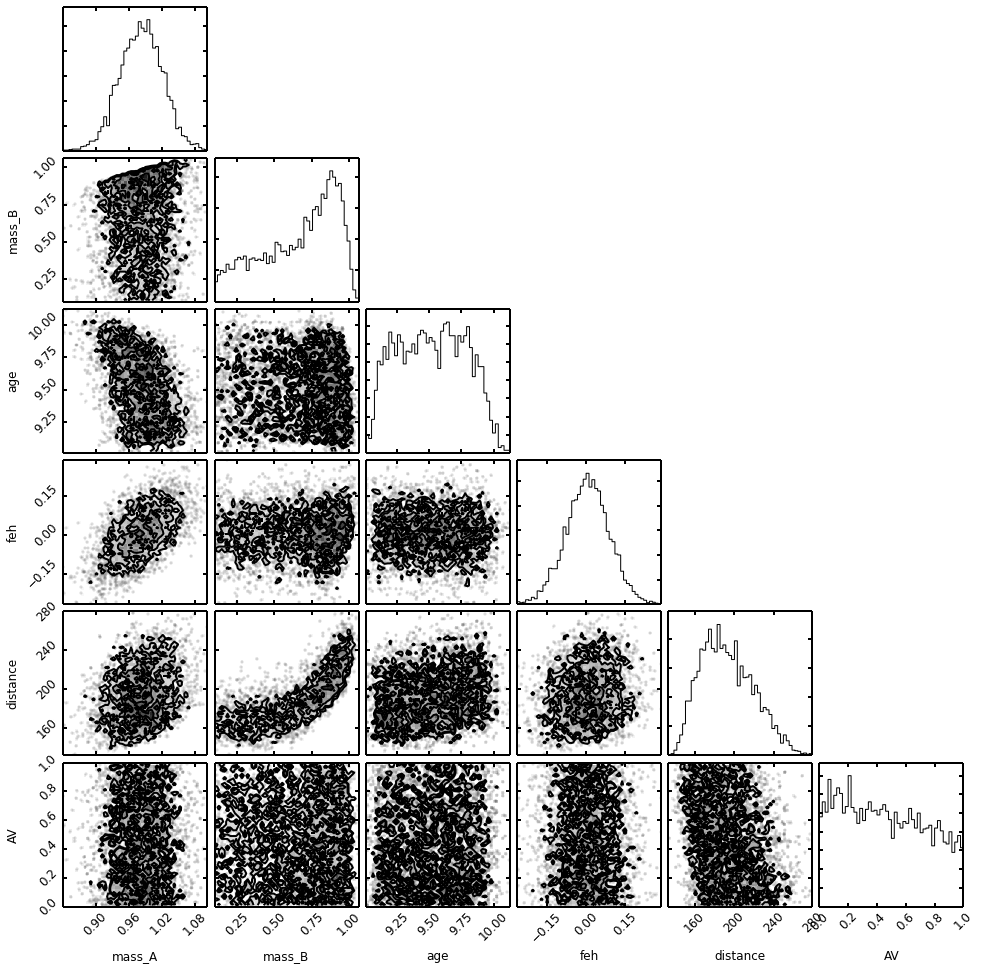

In [5]:
%matplotlib inline

mod.triangle();

In [90]:
# OK, now make an EBPopluation
from vespa import EBPopulation

try:
    rootLogger.setLevel(logging.INFO)
except:
    pass

N = 20000
P = np.logspace(0,3,N)
np.random.shuffle(P)

#ebpop = EBPopulation(period=2, starmodel=mod, n=N)
#ebpop.fit_trapezoids()
#ebpop.save_hdf('ebpop.h5', overwrite=True);
ebpop = EBPopulation.load_hdf('ebpop.h5')

In [12]:
ebpop.stars.columns

Index([u'level_0', u'H_mag', u'H_mag_A', u'J_mag', u'J_mag_A', u'K_mag',
       u'K_mag_A', u'Kepler_mag', u'Kepler_mag_A', u'Teff_A', u'age_A',
       u'g_mag', u'g_mag_A', u'i_mag', u'i_mag_A', u'logL_A', u'logg_A',
       u'mass_A', u'r_mag', u'r_mag_A', u'radius_A', u'z_mag', u'z_mag_A',
       u'H_mag_B', u'J_mag_B', u'K_mag_B', u'Kepler_mag_B', u'Teff_B',
       u'age_B', u'g_mag_B', u'i_mag_B', u'logL_B', u'logg_B', u'mass_B',
       u'r_mag_B', u'radius_B', u'z_mag_B', u'q', u'distance', u'distmod',
       u'Kepler_mag_1', u'Kepler_mag_2', u'Kepler_mag_tot', u'P', u'T14_pri',
       u'T14_sec', u'T23_pri', u'T23_sec', u'b_pri', u'b_sec', u'dpri',
       u'dsec', u'ecc', u'fluxfrac_1', u'fluxfrac_2', u'inc', u'switched',
       u'u1_1', u'u1_2', u'u2_1', u'u2_2', u'w', u'mass_1', u'radius_1',
       u'mass_2', u'radius_2', u'depth', u'duration', u'slope', u'secdepth',
       u'secondary'],
      dtype='object')

Let's list out the most likely relevant predictor features:

  * T14
  * T23
  * d [theoretical depth]
  * b
  * u1
  * u2
  * k

In [27]:
from vespa import PopulationSet
popset = PopulationSet.load_hdf('K06563.01/popset.h5')

In [28]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pop = popset['pl']
#pop = ebpop
ok = (pop.stars.depth > 0).values
stars = pop.stars[ok] #.query('depth > 0')

texp = 1626/86400.

# Define features
sec = stars.secondary
P = stars.P
T14 = sec*stars.T14_sec + ~sec*stars.T14_pri
T23 = sec*stars.T23_sec + ~sec*stars.T23_pri
T14 += texp
T23 = np.clip(T23-texp, 0, np.inf)
tau = (T14 - T23)/2.
#tau[tau < texp] = texp
#slope_anal = T14/tau
#slope_anal[slope_anal]
k = sec*(stars.radius_A/stars.radius_B) + ~sec*(stars.radius_B/stars.radius_A)
b = sec*(stars.b_sec/k) + ~sec*stars.b_pri
logd = np.log10(sec*stars.dsec + ~sec*stars.dpri)
u1 = sec*stars.u1_2 + ~sec*stars.u1_1
u2 = sec*stars.u2_2 + ~sec*stars.u2_1
#fluxfrac = sec*stars.fluxfrac_2 + ~sec*stars.fluxfrac_1
dilution = pop.dilution_factor[ok]

#X = np.array([P,T14,tau,k,b,logd,u1,u2,dilution,sec]).T
X = pop.eclipse_features
#X = np.concatenate([pop.eclipse_features for pop in popset.poplist])
inds = np.arange(len(X))
itest = inds % 5 == 0
itrain = ~itest
Xtest = X[itest, :]
Xtrain = X[itrain, :]

# Define targets
duration = stars.duration
logdepth = np.log10(stars.depth)
slope = stars.slope

Yslope = np.array(slope)
Ylogd = np.array(logdepth)
Ydur = np.array(duration)

#Ydur = np.concatenate([pop.eclipse_targets[0] for pop in popset.poplist])
#Ylogd = np.concatenate([pop.eclipse_targets[1] for pop in popset.poplist])
#Yslope = np.concatenate([pop.eclipse_targets[2] for pop in popset.poplist])

#Ydur, Ylogd, Yslope = pop.eclipse_targets

Yp = []
Yt = []
scores = []
for Y in [Yslope, Ylogd, Ydur]:
    Ytest = Y[itest]
    Ytrain = Y[itrain]

    #regr = LinearRegression()
    regr = RandomForestRegressor(n_estimators=10)
    #regr = SVR(kernel='rbf', C=1e3, gamma=0.1)
    pipeline = Pipeline([('scale', StandardScaler()), ('regression', regr)])
    #pipeline = Pipeline([('regression',regr)])

    pipeline.fit(Xtrain, Ytrain)
    Yp.append(pipeline.predict(Xtest))
    Yt.append(Ytest)
    scores.append(pipeline.score(Xtest, Ytest))

(2.0, 10)

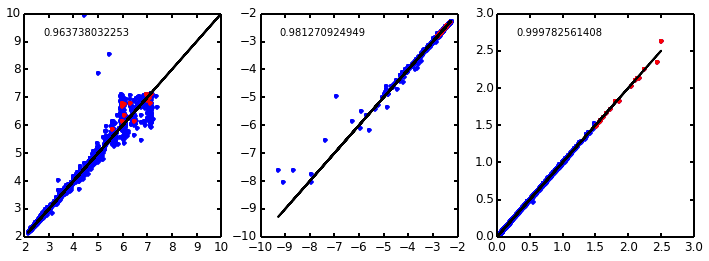

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12,4))

slope_diff = (np.abs(Yt[0]-Yp[0]))/Yt[0]
bad = slope_diff > 0.2
bad = Yt[2] > 1.5

for ax,(yt,yp),score in zip(axes, zip(Yt,Yp), scores):
    ax.plot(yt, yp, '.')
    ax.plot(yt[bad], yp[bad], 'r.')
    ax.plot(yt, yt, 'k-')
    ax.annotate(score, xy=(0.1,0.9), xycoords='axes fraction')
maxslope = 10
axes[0].set_xlim(xmax=maxslope)
axes[0].set_ylim(ymax=maxslope);
#print(np.where(bad))

In [39]:
cols = ['radius_A', 'radius_B', 'T14_pri', 'T14_sec', 'secondary',
       'depth','duration','slope', 'ecc','w', 'b_pri', 'b_sec', 'dsec', 'dpri',
       'fluxfrac_1', 'fluxfrac_2']
print(Yt[2][bad])
print(Yp[2][bad])
stars.loc[bad, cols]
stars.query('duration > 1.5')[cols]

[ 1.85281197  2.09691969  1.61232918  1.50614649  1.54878772  1.8024449
  1.72368622  1.57092277  1.6629183   2.50072026  2.13112211  1.50631624
  2.24020562  1.56277548  2.43319483  2.04733906  2.16401866]
[ 1.81855087  2.11243112  1.61198635  1.50292121  1.54180831  1.82715068
  1.71493802  1.55645278  1.6674519   2.62539421  2.13414597  1.48460837
  2.25488647  1.57375232  2.34575701  2.03003845  2.13495619]


,radius_A,radius_B,T14_pri,T14_sec,secondary,depth,duration,slope,ecc,w,b_pri,b_sec,dsec,dpri,fluxfrac_1,fluxfrac_2
40,4.573967,0.174722,1.761674,0.310367,False,0.001574,1.852812,6.303075,0.799368,292.507175,0.543634,0.081779,0,0.001653,1,0
257,4.601809,0.201664,2.625574,0.287306,False,0.002148,2.718631,7.036737,0.816038,271.426305,0.391806,0.039749,0,0.002265,1,0
467,5.514155,0.347429,1.500417,0.652070,False,0.004549,1.530279,7.182760,0.566166,314.921030,0.207445,0.088716,0,0.004803,1,0
784,4.969558,0.206363,1.763692,0.461902,False,0.001873,1.817029,7.085714,0.628748,275.797214,0.504497,0.116219,0,0.001978,1,0
928,5.220454,0.272442,1.515706,0.619163,False,0.003155,1.560685,7.135696,0.519006,305.917295,0.048766,0.019903,0,0.003324,1,0
959,4.598232,0.289544,1.806609,0.404470,False,0.004610,1.882153,6.002146,0.700419,245.564462,0.166370,0.036808,0,0.004813,1,0
1344,5.683509,0.308738,1.455554,0.780744,False,0.003331,1.516484,5.988455,0.352365,248.052768,0.388368,0.197040,0,0.003482,1,0
1693,4.994927,0.214176,1.660239,0.550776,False,0.002088,1.719797,7.051715,0.525037,280.022677,0.306767,0.097665,0,0.002200,1,0
1759,4.678084,0.280904,1.555140,0.528653,False,0.004208,1.623355,5.997901,0.532966,248.092714,0.111423,0.037690,0,0.004391,1,0
2835,4.328207,0.182752,2.010746,0.348845,False,0.002068,2.096920,6.979337,0.721160,257.756559,0.062320,0.010793,0,0.002175,1,0


{'p0': 0.86306415918215096, 'b': 1.8627470202155669, 'frac': 0.59385411516802433, 'u1': 0.26944782276065254, 'u2': 0.33440621135968279, 'P': 579.72891170000003, 'aR': 1009.5217465660928, 'w': 136.02299358768306, 'ecc': 0.46249102806300202}
[  2.31474649e-02   8.09568353e-08   8.53068121e+00]


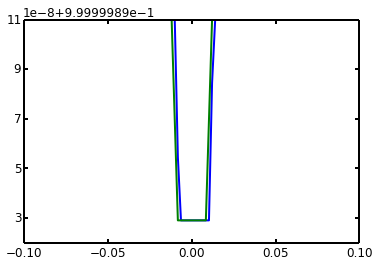

In [82]:
from vespa_transitutils import traptransit

i = 223
sec = False
pars = pop.eclipse_pars(i, secondary=sec)
ts,fs = pop.eclipse(i, secondary=sec, tol=1e-4)
plt.plot(ts, fs)
print(pars)
trap = np.array(pop.eclipse_trapfit(i, secondary=sec))
plt.plot(ts, traptransit(ts, trap))
print(trap)


In [42]:
from vespa.populations import PopulationSet

#popset = PopulationSet.load_hdf('K06705.01/popset.h5')
popset = PopulationSet.load_hdf('K00087.01/popset.h5')

pop = popset['beb_px2']

level_0                     45
H_mag                 4.838111
H_mag_A               4.838352
J_mag                    5.775
J_mag_A               5.775453
K_mag                 4.526646
K_mag_A               4.526832
Kepler_mag            10.02762
Kepler_mag_A          10.03872
Teff_A                    3501
age_A                     9.45
g_mag                 12.71985
g_mag_A               12.80954
i_mag                 9.274986
i_mag_A               9.280609
logL_A                3.353908
logg_A                    2.51
mass_A                 1.63939
r_mag                 11.57823
r_mag_A               11.62303
radius_A              150.3123
z_mag                 7.986582
z_mag_A               7.988259
H_mag_B               13.97494
J_mag_B               14.22438
K_mag_B               13.94222
Kepler_mag_B          15.00894
Teff_B                6149.662
age_B                     9.45
g_mag_B               15.47191
                      ...     
Kepler_mag_tot        10.02762
P       

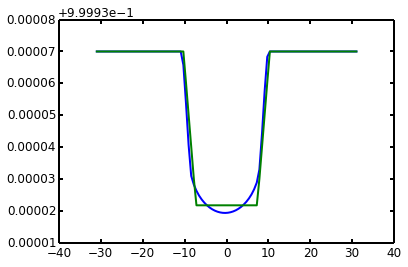

In [44]:
i = 45
print(pop.stars.ix[i])
sec = False
pars = pop.eclipse_pars(i, secondary=sec)
ts,fs = pop.eclipse(i, secondary=sec, tol=1e-4)
plt.plot(ts, fs)
print(pars)
trap = np.array(pop.eclipse_trapfit(i, secondary=sec))
plt.plot(ts, traptransit(ts, trap))
print(trap)

In [26]:
!scp -r tmorton@della:/tigress/tmorton/kepler/fpp/K06563.01 .

signal.png                                    100%   45KB  44.7KB/s   00:00    
results.txt                                   100%  276     0.3KB/s   00:00    
popset.h5                                     100%  115MB  10.5MB/s   00:11    
dartmouth_triangle_binary_physical.png        100% 1374KB   1.3MB/s   00:00    
eb.png                                        100%   52KB  51.9KB/s   00:00    
dartmouth_starmodel_triple.h5                 100% 3670KB   3.6MB/s   00:00    
lhoodcache.dat                                100% 1075     1.1KB/s   00:00    
dartmouth_triangle_binary_observed.png        100%  884KB 884.2KB/s   00:00    
dartmouth_mags_single.png                     100%   23KB  22.6KB/s   00:00    
dartmouth_mags_binary.png                     100%   22KB  22.5KB/s   00:00    
dartmouth_starmodel_binary.h5                 100% 2792KB   2.7MB/s   00:00    
dartmouth_triangle_single_physical.png        100%  370KB 370.4KB/s   00:00    
beb_Px2.png                             

In [83]:
import sys
sys.path.append('/u/tdm/repositories/peerless/prediction')
sys.path.append('/u/tdm/repositories/peerless')

from sims import BinaryPopulation
from targets import targets

pop = BinaryPopulation(targets)

In [7]:
%prun obs = pop.observe('period > 5', new=True)

In [4]:
obs[['period','trap_dur_pri','T14_pri','trap_dur_sec','T14_sec',
     'trap_depth_pri','d_pri','trap_depth_sec','d_sec','flux_ratio']]

,period,trap_dur_pri,T14_pri,trap_dur_sec,T14_sec,trap_depth_pri,d_pri,trap_depth_sec,d_sec,flux_ratio
468,9.852426,0.176193,0.191730,0.181772,0.191730,0.152430,0.156064,0.011765,0.011796,0.011937
777,34.385981,0.161995,0.173258,NaN,0.000000,0.128637,0.133421,NaN,0.000000,0.832501
879,25.053061,0.104596,0.116075,0.251390,0.269953,0.379952,0.390746,0.032947,0.034046,0.140927
955,44.205914,0.102258,0.105461,NaN,0.000000,0.027294,0.028579,NaN,0.000000,0.025366
1772,10.896998,NaN,0.000000,0.123232,0.130755,NaN,0.000000,0.009188,0.009524,0.021374
3427,8.505182,0.146859,0.160178,0.151533,0.160178,0.226040,0.234992,0.029748,0.030633,0.034107
5005,16.902246,0.151561,0.165178,0.155992,0.165178,0.213943,0.222017,0.077234,0.080244,0.090303
5375,5.298162,0.149564,0.165681,0.152925,0.165681,0.381232,0.388975,0.037441,0.037668,0.039142
5429,6.446318,0.056542,0.052389,0.039960,0.031863,0.002897,0.003220,0.000038,0.000048,0.004263
5529,197.938745,0.144608,0.151870,NaN,0.000000,0.083273,0.086043,NaN,0.000000,0.002964


In [10]:
def get_features(df, secondary=False, texp=1626./86400):
    if secondary:
        T14 = df.T14_sec
        T23 = df.T23_sec
        k = 1./df.k
        b = b_sec/df.k
        logd = np.log10(df.d_sec)
        sec = np.ones(len(df))
    else:
        T14 = df.T14_pri
        T23 = df.T23_pri
        k = df.k
        b = df.b_pri
        logd = np.log10(df.d_pri)
        sec = np.zeros(len(df))
    u1 = 0.394*np.ones(len(df))
    u2 = 0.296*np.ones(len(df))
    T14 += texp
    T23 = np.clip(T23 - texp, 0, T14)
    tau = (T14 - T23)/2.
    return np.array([T14, tau, k, b, logd, u1, u2, sec]).T

In [15]:
obs = pop.observe('period > 5')
X = get_features(obs)

In [18]:
obs.columns

Index([u'period', u'ecc', u'w', u'inc', u'a', u'b_pri', u'b_sec', u'k', u'tra',
       u'occ', u'd_pri', u'd_sec', u'T14_pri', u'T14_sec', u'T23_pri',
       u'T23_sec', u'dataspan', u'dutycycle', u'n_pri', u'n_sec'],
      dtype='object')

Most expensive parts of population simulations are exact isochrone interpolations of radius and magnitudes.  If we can make those analytic we're in good shape for fast population simulations.

In [22]:
from isochrones.dartmouth import Dartmouth_Isochrone
dar = Dartmouth_Isochrone()

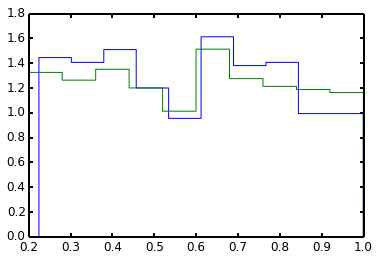

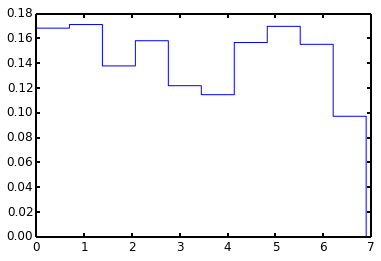

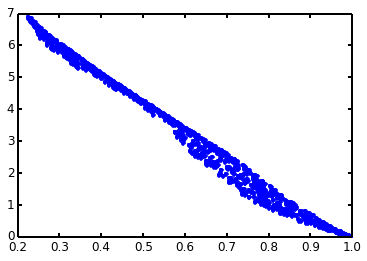

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

N = 1000
M1 = np.random.random(N) * 0.2 + 0.9
age = 9.4
feh = 0.0
q = np.random.random(N) * 0.8 + 0.2
M2 = q*M1
qrad = dar.radius(M2, age, feh)/dar.radius(M1, age, feh)
dmag = dar.mag['Kepler'](M2, age, feh) - dar.mag['Kepler'](M1, age, feh)

plt.hist(qrad, histtype='step', normed=True);
plt.hist(q, histtype='step', normed=True);
plt.figure()
plt.hist(dmag, histtype='step', normed=True);
plt.figure()
plt.plot(qrad, dmag, '.');

In [41]:
dar.tri.points.shape

(133803, 3)

In [66]:
%timeit pipeline.predict(Xtest)

10 loops, best of 3: 108 ms per loop


In [61]:
len(Xtest)

26796

In [1]:
from isochrones.dartmouth import Dartmouth_Isochrone
dar = Dartmouth_Isochrone()
dar.radius(1,9.5,0)

import sys
sys.path.append('/u/tdm/repositories/peerless/prediction')
sys.path.append('/u/tdm/repositories/peerless')

from sims import BinaryPopulation
from targets import targets

pop = BinaryPopulation(targets, fB=1)

/u/tdm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/u/tdm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [3]:
import numpy as np
M1 = np.ascontiguousarray(pop.mass_A)
M2 = np.ascontiguousarray(pop.mass_B)
feh = np.ascontiguousarray(pop.feh)
age = np.ascontiguousarray(pop.age)
R1 = dar.radius(M1, age, feh)
R2 = dar.radius(M2, age, feh)
qR = R2/R1

In [12]:
X = np.array([M1,feh,age,qR,R1]).T
y = dar.mag['Kepler'](M2, age, feh) - dar.mag['Kepler'](M1, age, feh)
ok = ~np.isnan(y)
X = X[ok, :]
y = y[ok]

0.9993634995886056

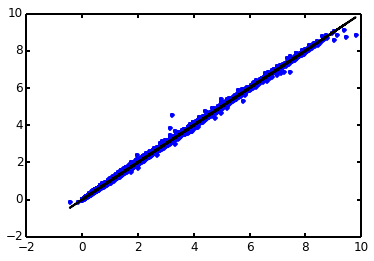

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars

u = np.random.random(X.shape[0])
itest = u < 0.2
itrain = u >= 0.2
Xtest = X[itest, :]
Xtrain = X[itrain, :]

ytest = y[itest]
ytrain = y[itrain]

regr = RandomForestRegressor(n_estimators=30)
#regr = LinearRegression()
pipeline = Pipeline([('scale', StandardScaler()), ('regress', regr)])

pipeline.fit(Xtrain,ytrain);
yp = pipeline.predict(Xtest)
plt.plot(ytest, yp, '.')
plt.plot(ytest, ytest, 'k-')
pipeline.score(Xtest, ytest)